In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
from joblib import Parallel, delayed

path_root = '../../../data'
path_data = '../../../data'
target_name = 'target'
scores_folds = {}

In [2]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return (np.sqrt(np.sum(series_log_return**2)))

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred)/y_true)))

def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # stock features
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    df_book['log_return1'] = df_book.groupby(by=['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by=['time_id'])['wap2'].apply(log_return).fillna(0)
    
    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    features_to_apply_realized_volatility = ['log_return'+str(i) for i in range(1, 3)]
    features_to_apply_realized_volatility += ['typical_price']
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[features_to_apply_realized_volatility].agg(realized_volatility).reset_index()
    
    # trade features
    trade_stat = pd.read_parquet(path_root + f'/trade_{dataType}.parquet/stock_id={stock_id}')
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return1'] = trade_stat.groupby(by=['time_id'])['price'].apply(log_return).fillna(0)
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[['trade_log_return1']].agg(realized_volatility).reset_index()
    
    # joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    return stock_stat_df

train = pd.read_csv(path_root + '/train.csv')
train_stock_stat_df = get_dataSet(stock_ids=train['stock_id'][:5].unique(), dataType='train')
train = pd.merge(train, train_stock_stat_df, on=['stock_id', 'time_id'], how='left').fillna(0)

In [71]:
# items: pd.Series
def log_1_return(items):
    items = items + 1
    return np.log(items + 1).diff()

def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # book data
    # bid_price1(2), ask_price1(2), bid_size1(2), ask_size1(2)
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    
    df_book['wap3'] = (df_book['bid_price1']*df_book['ask_size2'] + df_book['ask_price1']*df_book['bid_size2']) / (
                            df_book['bid_size1'] + df_book['bid_size2'])
    
    df_book['wap4'] = (df_book['bid_price1']*df_book['ask_size2'] + df_book['ask_price1']*df_book['bid_size2']) / (
                            df_book['ask_size1'] + df_book['ask_size2'])
    
    df_book['wap5'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1'] + df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size1'] + df_book['bid_size1'] + df_book['ask_size2'] + df_book['bid_size2'])
    
    for i in range(1, 6):
        df_book[f'log_return{i}'] = df_book.groupby(by=['time_id'])[f'wap{i}'].apply(log_return).fillna(0)

    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    df_book['TypicalPrice_log_return'] = df_book.groupby(by=['time_id'])['typical_price'].apply(log_return).fillna(0)
    features_to_apply_realized_volatility = ['log_return'+str(i) for i in range(1, 6)]
    features_to_apply_realized_volatility += ['TypicalPrice_log_return']
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[features_to_apply_realized_volatility].agg(realized_volatility).reset_index()
    
    # Trade data
    # price, size, order_count
    trade_stat = pd.read_parquet(path_root+f"/trade_{dataType}.parquet/stock_id={stock_id}")
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return'] = trade_stat.groupby(by='time_id')['price'].apply(log_return).fillna(0)
    
    # original features
    trade_stat['size_log_return'] = trade_stat.groupby(by='time_id')['size'].apply(log_1_return).fillna(0)
    trade_stat['orderCount_log_return'] = trade_stat.groupby(by='time_id')['order_count'].apply(log_1_return).fillna(0)
    trade_stat['volume'] = trade_stat['price'] * trade_stat['order_count']
    trade_stat['volume_log_return'] = trade_stat.groupby(by='time_id')['volume'].apply(log_1_return).fillna(0)
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[['trade_log_return', 'size_log_return', 'orderCount_log_return', 'volume_log_return']].agg(realized_volatility).reset_index()
    
    # joining book and trade data
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    return stock_stat_df

stock_df = get_dataSet(stock_ids=[0,5,10])
df = pd.read_csv(path_root + '/train.csv')
df = pd.merge(df.loc[df['stock_id'].isin([0, 5, 10])], stock_df, on=['stock_id', 'time_id'], how='left').fillna(0)
df['new_target'] = df['target'] / df['log_return1']
df.head()

,stock_id,time_id,target,log_return1,log_return2,log_return3,log_return4,log_return5,TypicalPrice_log_return,trade_log_return,size_log_return,orderCount_log_return,volume_log_return,new_target
0,0,5,0.004136,0.004499,0.006999,21.770443,20.893744,0.004106,0.002395,0.002006,16.743341,3.642010,3.647071,0.919188
1,0,11,0.001445,0.001204,0.002476,9.135033,10.148571,0.001507,0.000714,0.000901,12.502979,2.560090,2.560417,1.199426
2,0,16,0.002168,0.002369,0.004801,8.724044,11.299487,0.002469,0.001620,0.001961,11.590192,2.984806,2.983895,0.915385
3,0,31,0.002195,0.002574,0.003637,9.818654,5.201563,0.002708,0.001698,0.001561,6.829874,2.853436,2.852248,0.852949
4,0,62,0.001747,0.001894,0.003257,16.458035,15.680884,0.001932,0.001128,0.000871,11.551998,3.820016,3.819600,0.922325


In [86]:
df['log_return1and4'] = df['log_return1'] * df['log_return4']

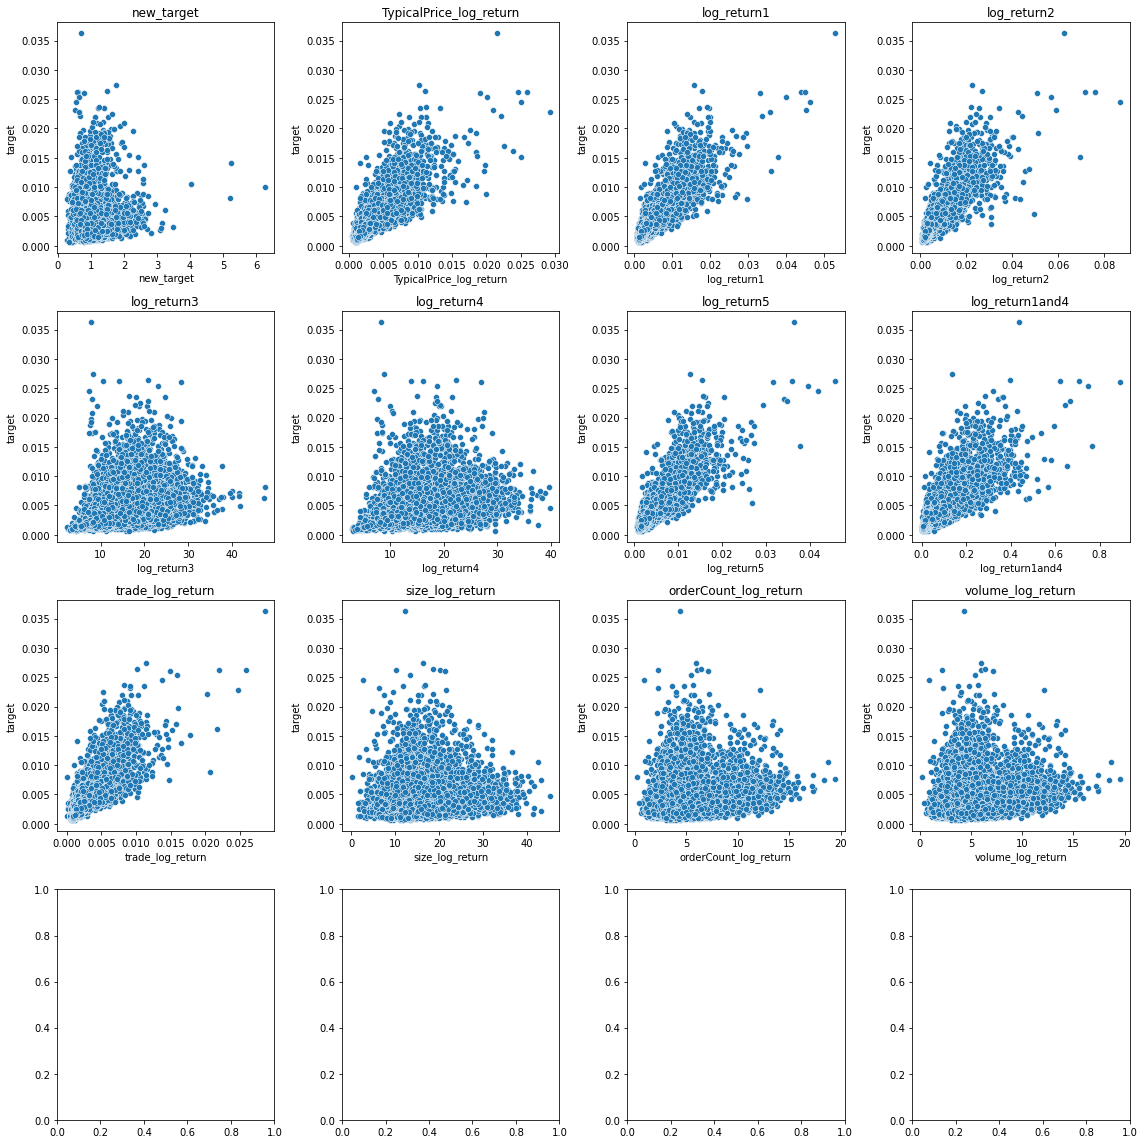

In [87]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()
cols = ["new_target", "TypicalPrice_log_return", "log_return1", "log_return2", "log_return3", "log_return4", "log_return5", "log_return1and4",
        "trade_log_return", "size_log_return", "orderCount_log_return", "volume_log_return"]
for i in range(len(cols)):
    ax = axs[i]
    sns.scatterplot(data=df, x=cols[i], y='target', ax=ax)
    ax.set_title(cols[i])
    
plt.tight_layout()

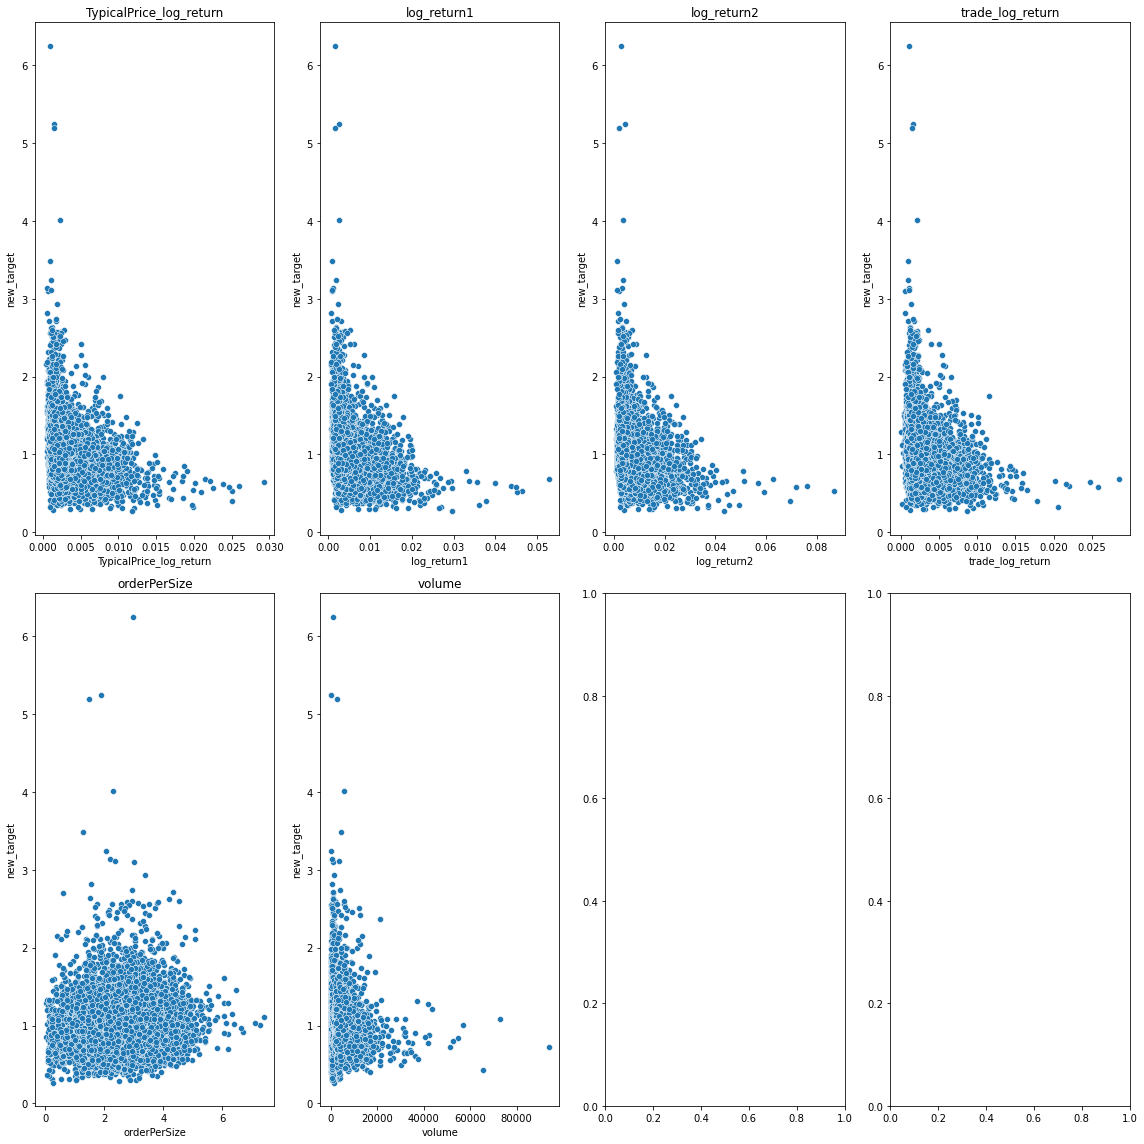

In [61]:
fig, axs = plt.subplots(2, 4, figsize=(16, 16))
axs = axs.flatten()
cols = ["TypicalPrice_log_return", "log_return1", "log_return2", "trade_log_return", "orderPerSize", "volume"]
for i in range(len(cols)):
    ax = axs[i]
    sns.scatterplot(data=df, x=cols[i], y='new_target', ax=ax)
    ax.set_title(cols[i])
    
plt.tight_layout()

TypeError: can only concatenate list (not "int") to list